<a href="https://colab.research.google.com/github/SHAMIK-97/NLP-GenerativeQA/blob/main/Text_mining_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00


In [3]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.4 MB/s eta 0:00:00


In [4]:
! pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 6.1 MB/s eta 0:00:00


##Abstract

The text extractor and the encoder-decoder are two pretrained transformer-based modules that we present in
this paper as a model for tackling the QaA challenge.
Such a model is trained by a single loss. Regarding the
average SQuAD F1 score, the results are satisfactory. Falcon-7B pretrained model is used for inferencing for a comparative study.

## Introduction

Answering questions that refer to sections that have the
necessary information is known as question answering
(QA). Additionally, the history of prior question-andanswer turns may be used to generate the response.
In this project, I employ a model made up of
the Text Extractor (TE) and the Encoder-Decoder (ED)
modules. We are encoding the most likely text span
(answer span) and feeding it to do encoder decoder
model for the generation of the answer. This strategy
is used since the passage may be quite long and it will
aid the encoder-decoder in discovering the interesting
information. Both modules are constructed using a
transformer-based pre-trained design.
The CoQA dataset, utilizing the specified trainingtest split and further dividing the training into trainingvalidation, with proportions of 0.80.2, is the dataset being considered. Questions that cannot be answered are
removed.
The pre-trained transformer-based designs DistilRoBERTa and BERTTiny were both employed. Three
distinct random seeds have been examined for both
models. There have been a total of 12 distinct studies
conducted because the conversational history could be
taken into account or not. Falcon-7B pretrained model is used for inferencing as a comparative study with DistilRoberta and Berttiny.

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModel, AutoModelForCausalLM, FalconForQuestionAnswering
import tensorflow as tf
from datasets import load_metric
from keras.models import load_model
import tensorflow_addons as tfa
import ssl
import os
import urllib.request
from tqdm import tqdm
from copy import deepcopy
import time
import transformers
import torch
tf.config.run_functions_eagerly(True)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


## Downloading the Data

In [7]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):
    if not os.path.exists(data_path):
        os.makedirs(data_path)

    data_path = os.path.join(data_path, f'{suffix}.json')

    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [8]:
# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path='coqa', url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path='coqa', url_path=test_url, suffix='test')

coqa-train-v1.0.json: 49.0MB [00:08, 6.05MB/s]                            


Download completed!


coqa-dev-v1.0.json: 9.09MB [00:02, 3.16MB/s]                            

Download completed!


## Extracting Dataset

In [9]:
def extract_dataset(download_path: str):
    try:
      print("Extracting dataset... (it may take a while...)")
      coqa = pd.read_json(download_path)
      print("Extraction completed!")
      return coqa
    except Exception as e:
      print(e)
      print("-------------")
      print("Please give the proper file path!")


coqa_train =   extract_dataset('/content/coqa/train.json')
coqa_test =  extract_dataset('/content/coqa/test.json')

Extracting dataset... (it may take a while...)
Extraction completed!
Extracting dataset... (it may take a while...)
Extraction completed!


## Data cleaning and converting dataset to dataframe

In [10]:
del coqa_train["version"]


In [11]:
def converting(df : pd.DataFrame, type = 0):
  '''
  type : For train set type =0, otherwise. For test set we are not removing the
         unknown QA pair
  '''
  #required columns in our dataframe
  cols = ["source","text","question","history","answer", "context"]
  #list of lists to create our dataframe
  comp_list = []
  for index, row in tqdm(df.iterrows()):
    history = []
    for i in range(len(row["data"]["questions"])):
      temp_list = []
      tmp = {}
      history_local = []
      temp_list.append(row["data"]["source"])
      temp_list.append(row["data"]["story"])
      temp_list.append(row["data"]["questions"][i]["input_text"])
      tmp["input_text"] = row["data"]["answers"][i]["input_text"]
      tmp['span_start'] = [row['data']['answers'][i]['span_start']]
      tmp['span_end'] = [row['data']['answers'][i]['span_end']]
      if type == 0:
        if row["data"]["answers"][i]["input_text"] != 'unknown':
          history.append(row["data"]["questions"][i]["input_text"] + row["data"]["answers"][i]["input_text"])

      else: # we are not omitting the unknown question answer pairs in test set
        history.append(row["data"]["questions"][i]["input_text"] + row["data"]["answers"][i]["input_text"])

      history_local = deepcopy(history)
      if  history_local:
        element = history_local.pop()  # history should contain QA pair upto turn_id =i-1
      temp_list.append(history_local)
      temp_list.append(tmp)
      history_string = ''
      if history_local:
        history_string = [''.join(p) for p in history_local][0]
      joined  =   row["data"]["questions"][i]["input_text"] + history_string
      temp_list.append(joined)
      comp_list.append(temp_list)

  new_df = pd.DataFrame(comp_list, columns=cols)
  return new_df

print("Converting train data to dataframe.....")
train = converting(coqa_train)
print("Conversion Complete!")
print("Converting test data to dataframe.....")
test = converting(coqa_test, 1)
print("Conversion Complete!")

Converting train data to dataframe.....


7199it [00:06, 1160.79it/s]


Conversion Complete!
Converting test data to dataframe.....


500it [00:00, 1265.69it/s]

Conversion Complete!


##[Task-1] Removing Unanswerable questions from train set

In [12]:
# Retriving the row indices whose answers are unknown
unk = train.index[[index for index, rows in train['answer'].items() if rows['input_text'] == 'unknown']]
print("Number questions unanswerable : {}".format(len(unk)))

# Removing the unanswarable questions
train_modfied = train.drop(unk)
# Re arranging the index
train_modfied.index = range(len(train_modfied))

Number questions unanswerable : 1371


## Description:
The train dataset contains 6 columns. First column is Source. Second column is text that is the passage. 3rd column is the question. 4th column is the history which means the conversation history prior to the question. 5th column is the answer to the question. 6th column is the context which contains the question plus the history.

In [13]:
train_modfied

,source,text,question,history,answer,context
0,wikipedia,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,[],{'input_text': 'It was formally established in...,When was the Vat formally opened?
1,wikipedia,"The Vatican Apostolic Library (), more commonl...",what is the library for?,[When was the Vat formally opened?It was forma...,"{'input_text': 'research', 'span_start': [454]...",what is the library for?When was the Vat forma...
2,wikipedia,"The Vatican Apostolic Library (), more commonl...",for what subjects?,[When was the Vat formally opened?It was forma...,"{'input_text': 'history, and law', 'span_start...",for what subjects?When was the Vat formally op...
3,wikipedia,"The Vatican Apostolic Library (), more commonl...",and?,[When was the Vat formally opened?It was forma...,"{'input_text': 'philosophy, science and theolo...",and?When was the Vat formally opened?It was fo...
4,wikipedia,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,[When was the Vat formally opened?It was forma...,"{'input_text': 'a project', 'span_start': [76...",what was started in 2014?When was the Vat form...
...,...,...,...,...,...,...
107271,cnn,(CNN) -- Cristiano Ronaldo provided the perfec...,Who was a sub?,"[Who was in charge of FIFA?Sepp Blatter, What ...","{'input_text': 'Xabi Alonso', 'span_start': [1...",Who was a sub?Who was in charge of FIFA?Sepp B...
107272,cnn,(CNN) -- Cristiano Ronaldo provided the perfec...,Was it his first game this year?,"[Who was in charge of FIFA?Sepp Blatter, What ...","{'input_text': 'Yes', 'span_start': [1415], 's...",Was it his first game this year?Who was in cha...
107273,cnn,(CNN) -- Cristiano Ronaldo provided the perfec...,What position did the team reach?,"[Who was in charge of FIFA?Sepp Blatter, What ...","{'input_text': 'third', 'span_start': [1520], ...",What position did the team reach?Who was in ch...
107274,cnn,(CNN) -- Cristiano Ronaldo provided the perfec...,Who was ahead of them?,"[Who was in charge of FIFA?Sepp Blatter, What ...","{'input_text': 'Barca.', 'span_start': [1557],...",Who was ahead of them?Who was in charge of FIF...


In [14]:
test

,source,text,question,history,answer,context
0,mctest,"Once upon a time, in a barn near a farm house,...",What color was Cotton?,[],"{'input_text': 'white', 'span_start': [59], 's...",What color was Cotton?
1,mctest,"Once upon a time, in a barn near a farm house,...",Where did she live?,[What color was Cotton?white],"{'input_text': 'in a barn', 'span_start': [18]...",Where did she live?What color was Cotton?white
2,mctest,"Once upon a time, in a barn near a farm house,...",Did she live alone?,"[What color was Cotton?white, Where did she li...","{'input_text': 'no', 'span_start': [196], 'spa...",Did she live alone?What color was Cotton?white
3,mctest,"Once upon a time, in a barn near a farm house,...",Who did she live with?,"[What color was Cotton?white, Where did she li...","{'input_text': 'with her mommy and 5 sisters',...",Who did she live with?What color was Cotton?white
4,mctest,"Once upon a time, in a barn near a farm house,...",What color were her sisters?,"[What color was Cotton?white, Where did she li...","{'input_text': 'orange and white', 'span_start...",What color were her sisters?What color was Cot...
...,...,...,...,...,...,...
7978,wikipedia,"Las Vegas (, Spanish for ""The Meadows""), offic...","where does the nickname ""Sin City"" come from?","[what does Las Vegas mean?""The Meadows"", What ...",{'input_text': 'The city's tolerance for numer...,"where does the nickname ""Sin City"" come from?w..."
7979,wikipedia,"Las Vegas (, Spanish for ""The Meadows""), offic...",Which state is it in?,"[what does Las Vegas mean?""The Meadows"", What ...","{'input_text': 'Nevada', 'span_start': [100], ...",Which state is it in?what does Las Vegas mean?...
7980,wikipedia,"Las Vegas (, Spanish for ""The Meadows""), offic...",Is it located in a desert?,"[what does Las Vegas mean?""The Meadows"", What ...","{'input_text': 'Yes', 'span_start': [326], 'sp...",Is it located in a desert?what does Las Vegas ...
7981,wikipedia,"Las Vegas (, Spanish for ""The Meadows""), offic...",what is the name of the desert?,"[what does Las Vegas mean?""The Meadows"", What ...","{'input_text': 'Mojave Desert.', 'span_start':...",what is the name of the desert?what does Las V...


##[Task 2] Train, Validation and Test splits

In [60]:
# Random split
seed = [42, 2022]
x_train, x_val, y_train, y_val = train_test_split(train_modfied[['source', 'text', 'question', 'context']], train_modfied['answer'],
                                                  train_size=0.80,
                                                  test_size=0.20,
                                                  random_state=seed[0])


train_combined = pd.concat([x_train, y_train], axis=1)
validation_combined = pd.concat([x_val, y_val], axis=1)

In [16]:
# It contains the X_label and y_label
train_combined

,source,text,question,context,answer
25827,race,Bob is a middle school student. He is 13years ...,is Jack his twin?,is Jack his twin?when does Bob get up in the m...,"{'input_text': 'yes', 'span_start': [92], 'spa..."
23316,race,Characters in novels don't always do what the ...,What can be a huge hurdle for writers?,What can be a huge hurdle for writers?,{'input_text': 'When characters don't do what ...
24902,cnn,(CNN) -- Jason Day nearly pulled out of the Wo...,What athlete is the article about?,What athlete is the article about?,"{'input_text': 'Jason Day', 'span_start': [9],..."
99000,race,While Americans feel worried about how to look...,What do they eat for a snack?,What do they eat for a snack?Do French parents...,"{'input_text': 'One snack at about 4:00 pm, do..."
66298,wikipedia,300 (three hundred) is the natural number foll...,What three primes in a row is 301 the sum of?,What three primes in a row is 301 the sum of?W...,"{'input_text': '(13 + 17 + 19 +', 'span_start'..."
...,...,...,...,...,...
46769,gutenberg,Chapter 14: The End Of The Persecutor. \n\nSig...,Did they land?,Did they land?Who had a daughter?Polani,"{'input_text': 'Yes', 'span_start': [204], 'sp..."
103024,mctest,Jenny was a 13 year old girl with blond hair a...,How long did it take?,How long did it take?Did the girls fall asleep...,"{'input_text': 'all day', 'span_start': [569],..."
16557,cnn,Washington (CNN) -- The United States is watch...,and who is he?,and who is he?Is this scrutiny something Kayan...,{'input_text': 'chairman of the U.S. Joint Chi...
1244,cnn,(CNN) -- Serbia will face France in the final ...,What is Berdych's nationality?,What is Berdych's nationality?Who will Serbia ...,"{'input_text': 'Czech', 'span_start': [543], '..."


In [17]:
validation_combined

,source,text,question,context,answer
90516,cnn,(CNN) -- Rory McIlroy has won the Deutsche Ban...,Who was leading overnight?,Who was leading overnight?Who is the winner of...,"{'input_text': 'Louis Oosthuizen', 'span_start..."
17794,wikipedia,The Encyclopedia of Mathematics (also EOM and ...,What the CD contains?,What the CD contains?What EOM stands for?Encyc...,{'input_text': 'animations and three-dimension...
18465,gutenberg,CHAPTER TWENTY. \n\nKEEPING IT DOWN--MUTUAL EX...,What were they frying?,What were they frying?What was the 1st impulse...,"{'input_text': 'steaks', 'span_start': [1568],..."
34267,wikipedia,The Silurian is a geologic period and system s...,like?,like?How long the Silurian period lasted?24.6 ...,"{'input_text': 'bryophyte', 'span_start': [653..."
54190,wikipedia,"John Ronald Reuel Tolkien, (; 3 January 1892 –...",Isn't there another?,Isn't there another?Who is featured in this ar...,"{'input_text': 'yes', 'span_start': [242], 'sp..."
...,...,...,...,...,...
105234,race,"For Iris Grace Halmshaw, the world was a lonel...",Why did Iris and Thula meet?,Why did Iris and Thula meet?What was Iris's la...,{'input_text': 'Iris's parents were trying ani...
53071,mctest,"One day, a boy named Jack wanted take a trip o...",What did he put in his backpack?,What did he put in his backpack?What color was...,"{'input_text': 'pizza', 'span_start': [409], '..."
94068,wikipedia,The Royal College of Chemistry was established...,How many businesses caused it to come about?,How many businesses caused it to come about?Wh...,"{'input_text': '16', 'span_start': [571], 'spa..."
81864,cnn,They hugged at the Rafah border crossing. Chee...,Where did he receive a hero's welcome?,Where did he receive a hero's welcome?What did...,"{'input_text': 'Mitzpe Hila, Israel', 'span_st..."


##Initializing the Tokenizers

In [18]:
tokenizer1 = AutoTokenizer.from_pretrained('distilroberta-base')
tokenizer2 = AutoTokenizer.from_pretrained('prajjwal1/bert-tiny')
tokenizer3 = AutoTokenizer.from_pretrained("tiiuae/falcon-7b")

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

##Tokenizing the Data

Here we are tokenizing the train data and train lebels. The model will take input as the #input_ids, #input_attention_mask.

This piece of code is largely taken from https://github.com/huggingface/notebooks/blob/main/examples/question_answering-tf.ipynb

In [19]:
def prepare_train_features(examples,tokenizer ,use_Falcon=False,history = False,pad_on_right=True,max_length=512,doc_stride=128):
    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = None

    if use_Falcon:
       if history:
          inputs = tokenizer(
              examples["question"],
              examples["context"],
              add_special_tokens=True,
              return_tensors = 'pt')
       else:
          inputs = tokenizer(
              examples["question"],
              examples["text"],
              add_special_tokens=True,
              return_tensors = 'pt')

       return inputs,_

    if history == False:
      tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "text"],
        examples["text" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length"

      )
    else:
      tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length"

      )



    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []
    tokenized_examples['offset_mapping'] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answer"]['input_text'][sample_index: sample_index+1]
        # If no answers are given, set the cls_index as answer.
        if examples['answer']["span_start"][0] == -1:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = examples['answer']["span_start"][0]
            end_char = examples['answer']["span_end"][0]

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (
                offsets[token_start_index][0] <= start_char
                and offsets[token_end_index][1] >= end_char
            ):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while (
                    token_start_index < len(offsets)
                    and offsets[token_start_index][0] <= start_char
                ):
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    # tokenizing the y labels

    output_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<UNK>')
    an = ['<start> '+examples['answer']['input_text']+' <end>']
    output_tokenizer.fit_on_texts(an)

    output_vocab_size = len(output_tokenizer.word_index) + 1

    encoded_output_sample = output_tokenizer.texts_to_sequences(an)
    encoded_output_sample = tf.keras.preprocessing.sequence.pad_sequences(encoded_output_sample,
                                                                          padding='post',
                                                                          maxlen=353)
    max_output_length = max([len(item) for item in encoded_output_sample])



    tokenized_examples['offset_mapping'].append(offset_mapping)
    batch1 = {}
    batch1['input_ids'] = tf.convert_to_tensor(tokenized_examples['input_ids'])
    batch1['attention_mask'] = tf.convert_to_tensor(tokenized_examples['attention_mask'])
    batch1['start_token_idx'] = tf.convert_to_tensor(tokenized_examples['start_positions'])
    batch1['end_token_idx'] = tf.convert_to_tensor(tokenized_examples['end_positions'])
    batch1['encoded_output_sample'] = encoded_output_sample
    batch1['output_vocab_size'] = output_vocab_size
    offset_mapping =np.array(tokenized_examples['offset_mapping']).flatten().tolist()
    #offset_mapping = tf.reshape(offset_mapping, tuple(offset_mapping.shape[0:, :])).numpy()[1:]
    #print(f'offset_mapping shape - {offset_mapping.shape}')
    batch1['offset_mapping'] = offset_mapping
    batch1['text'] = examples['text']
    batch1['max_output_length'] = max_output_length
    batch1['extracted_answer'] = an
    batch1['output_tokenizer'] = output_tokenizer
    return batch1, tokenized_examples

## Implementing the Trainer Class to train the model (The seq2seq model)

In [28]:
class MyTrainer(object):
    """
    Simple wrapper class

    train_op -> uses tf.GradientTape to compute the loss
    batch_fit -> receives a batch and performs forward-backward passes (gradient included)
    """

    def __init__(self, encoder, decoder, max_length=353):
        self.encoder = encoder
        self.decoder = decoder
        self.max_length = max_length
        self.ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-03)

    @tf.function
    def compute_loss(self, logits, target):
        loss = self.ce(y_true=target, y_pred=logits)
        mask = tf.logical_not(tf.math.equal(target, 0))
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_mean(loss)

    @tf.function
    def train_op(self, inputs):
        with tf.GradientTape() as tape:
            encoder_output, encoder_h, encoder_s, _= self.encoder(inputs['inputs'])

            decoder_input = inputs['decoder_target'][:, :-1]  # ignore <end>
            real_target = inputs['decoder_target'][:, 1:]  # ignore <start>

            self.decoder.attention.setup_memory(encoder_output)

            decoder_initial_state = self.decoder.build_initial_state(1, [encoder_h, encoder_s])
            predicted = self.decoder({'input_ids': decoder_input,
                                      'initial_state': decoder_initial_state}).rnn_output

            loss = self.compute_loss(logits=predicted, target=real_target)

        grads = tape.gradient(loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        return loss, grads

    @tf.function
    def batch_fit(self, inputs):
        loss, grads = self.train_op(inputs=inputs)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_variables + self.decoder.trainable_variables))
        return loss

    # @tf.function
    def generate(self, input):
        batch_size = 1 #input_ids.shape[0]
        encoder_output, encoder_h, encoder_s, max_length_encoder = self.encoder(input)

        start_tokens = tf.fill([batch_size], input['output_tokenizer'].word_index['<start>'])
        end_token = input['output_tokenizer'].word_index['<end>']

        greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()
        decoder_instance = tfa.seq2seq.BasicDecoder(cell=self.decoder.wrapped_decoder_cell,
                                                    sampler=greedy_sampler,
                                                    output_layer=self.decoder.generation_dense,
                                                    maximum_iterations=max_length_encoder)
        self.decoder.attention.setup_memory(encoder_output)

        decoder_initial_state = self.decoder.build_initial_state(batch_size, [encoder_h, encoder_s])
        decoder_embedding_matrix = self.decoder.embedding.variables[0]
        outputs, _, _ = decoder_instance(decoder_embedding_matrix,
                                         start_tokens=start_tokens,
                                         end_token=end_token,
                                         initial_state=decoder_initial_state)
        return outputs

    def translate(self, generated, output_tokenizer):
      output = output_tokenizer.sequences_to_texts(generated.sample_id.numpy())[0].split(' ')
      seen = set()
      result = []
      str = ''
      for item in output:
          if item not in seen:
              seen.add(item)
              str = str+' '+item+' '
      return str

## Declaring the model class.(The seq2seq model)

The model takes in input the question, the passage and, optionally, the history, and it generates the answer. If given, the history is a single string where the different turns are separated with the special separator token '<sep>'. The history is used by concatenating it with the question, using the same special token '<sep>', and then this concatenated string is given in input to the model.

This model consists of two modules.

The first one is the text extractor. Given the question and the passage (and, optionally, the history) it produces the span text: for each passage token, a span
 is produced, representing the span text of that passage token which is likely to be the answer.
The second module is the encoder-decoder, i.e. the seq2seq model. Given the question, the passage (and, optionally, the history) and the span, it generates the answer.
The reason for structuring in this way the model is the following. If we use only the encoder-decoder for generating the answer, the model can have difficulties in finding the interesting and useful information in the passage, since it can be very long. Therefore, adding a module which gives an importance to each token, it can help the encoder-decoder in the answer generation. Basically, the purpose is similar to have a module which extracts the span of interest from the passage and then another module for generating an answer out of the extracted span. But the approach is different: we give an importance score to each passage token. The following image shows the span produced by the extractor for a certain sample versus the true passage span.

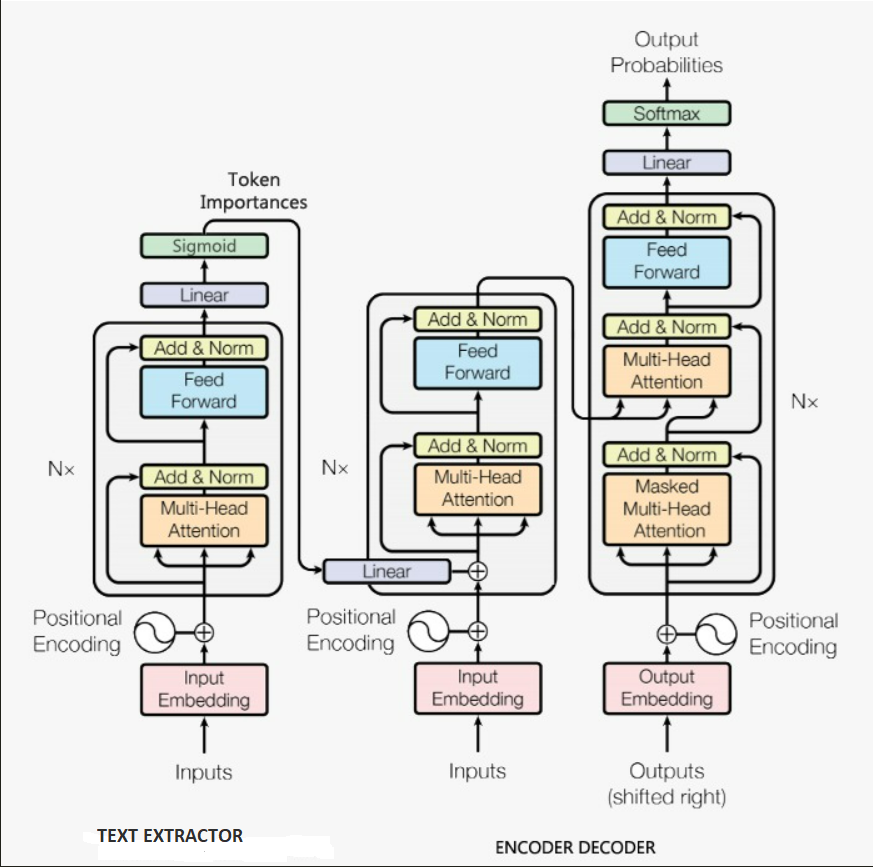


Both the text extractor and the encoder-decoder are built from a pre-trained transformer-based architecture. In particular, two kinds of pre-trained models can be specified.

\textbf{Bert tiny}: 'prajjwal1/bert-tiny'. The text extractor is built from the bert-tiny encoder; the encoder-decoder is built from the bert-tiny encoder-decoder.

\textbf{Distil roberta}: 'distilroberta-base'. The text extractor is built from the distil roberta encoder; the encoder-decoder is built from the distil roberta encoder-decoder.

In [21]:
class Encoder(tf.keras.Model):

  def __init__(self, model_name, tokenizer):
    super(Encoder, self).__init__()
    self.tokenizer = tokenizer
    #self.text_extractor = TFAutoModel.from_pretrained('bert-base-uncased', from_pt=True)
    self.model = TFAutoModel.from_pretrained(model_name, from_pt=True)
    # self.decoder_units = decoder_units
    # self.reducer = tf.keras.layers.Dense(self.decoder_units)

  def convertor(self,inputs,tokenizer, start_probs,end_probs):
    '''
    This function takes the token span probabilities, extract the answer span, given the passage.
    Encode them to feed into the encoder for generation
    '''
    answer = ''
    text = inputs['text']
    answer_start = answer_end = 0
    score = 0
    offsets = inputs['offset_mapping']
    valid_answers = []
    encoded_inputs = None

    start_indices = np.argsort(start_probs.numpy()).tolist()[0][:20]
    end_indices = np.argsort(end_probs.numpy()).tolist()[0][:20]
    for (start_index, end_index) in zip(start_indices, end_indices):
      start = start_index
      end = end_index
      if (start <= end) and start+1 < len(offsets) and start>=0:
        answer_start = offsets[start+1]
        if end >= len(offsets):
          answer_end = offsets[len(offsets)-1]
        else:
          answer_end = offsets[end+2]
        score = start + end
        answer = text[answer_start: answer_end]
        valid_answers.append(
                {
                    "score": score,
                    "text":answer
                })
      else:
        continue

    if len(valid_answers)>0:
      valid_answers_modified = sorted(valid_answers, key=lambda x: x["score"], reverse=True)
      valid_answers_modified = [ans['text'] for ans in valid_answers_modified if ans['text']!='']
      if len(valid_answers_modified)>0:
        answer = valid_answers_modified[0]
    if answer !='':
      encoded_inputs = tokenizer(answer, return_tensors='tf', padding=True)#, padding='max_length',truncation="only_first", max_length=353)
    else:
      answer = ['<start> <unk> <end>'] #inputs['extracted_answer']
      encoded_inputs = tokenizer(answer, return_tensors='tf', padding=True)#, padding='max_length',truncation="only_first", max_length=353)

    #encoded_inputs = tf.keras.preprocessing.sequence.pad_sequences(encoded_inputs,padding='post',maxlen=353)
    return encoded_inputs.input_ids , encoded_inputs.attention_mask, encoded_inputs.input_ids.shape[-1]



  def call(self, inputs, training=False, **kwargs):
    embedding = self.model(inputs['input_ids'],inputs['attention_mask'])[0]
    start_logits = tf.keras.layers.Dense(1, name="start_logit", use_bias=False)(embedding)
    start_logits = tf.keras.layers.Flatten()(start_logits)

    end_logits = tf.keras.layers.Dense(1, name="end_logit", use_bias=False)(embedding)
    end_logits = tf.keras.layers.Flatten()(end_logits)

    start_probs = tf.keras.layers.Activation(tf.keras.activations.softmax)(start_logits)
    end_probs = tf.keras.layers.Activation(tf.keras.activations.softmax)(end_logits)
    input_ids, attention_mask , max_input_length = self.convertor(inputs,self.tokenizer, start_probs,end_probs)
    model_output = self.model({'input_ids': input_ids,'attention_mask': attention_mask})
    all_outputs = model_output[0]
    pooled_output = model_output[1]
    pooled_output = tf.keras.layers.Dense(16)(pooled_output)
    return all_outputs, pooled_output, pooled_output, max_input_length


class Decoder(tf.keras.Model):

  def __init__(self,max_sequence_length=353,vocab_size=210, embedding_dim=50, decoder_units=16, batch_size=1):
    super(Decoder, self).__init__()

    self.max_sequence_length = max_sequence_length
    self.batch_size = batch_size

    self.decoder_units = decoder_units
    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                   output_dim=embedding_dim)
    self.decoder_lstm_cell = tf.keras.layers.LSTMCell(self.decoder_units)

    self.attention = tfa.seq2seq.BahdanauAttention(units=self.decoder_units,
                                                       memory=None,
                                                       memory_sequence_length=self.batch_size * [max_sequence_length])

    self.wrapped_decoder_cell = tfa.seq2seq.AttentionWrapper(self.decoder_lstm_cell,
                                                                 self.attention,
                                                                 attention_layer_size=self.decoder_units)

    self.generation_dense = tf.keras.layers.Dense(vocab_size)
    self.sampler = tfa.seq2seq.sampler.TrainingSampler()
    self.decoder = tfa.seq2seq.BasicDecoder(self.wrapped_decoder_cell,
                                                sampler=self.sampler,
                                                output_layer=self.generation_dense)

  def build_initial_state(self, batch_size, encoder_state):
    initial_state = self.wrapped_decoder_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
    initial_state = initial_state.clone(cell_state=encoder_state)
    return initial_state

  def call(self, inputs, training=False, **kwargs):
    input_ids = inputs['input_ids']
    input_emb = self.embedding(input_ids)
    decoder_output, _, _ = self.decoder(input_emb,
                                            initial_state=inputs['initial_state'],
                                            sequence_length=self.batch_size * [self.max_sequence_length - 1])
    return decoder_output

## Below are the paths to the saved encoder models

In [22]:
model_name1 = 'distilroberta-base'
model_name2 = 'prajjwal1/bert-tiny'

## Defining the Train funtion

In [81]:
def train(epoch=0,data=train_combined, data_val=train_combined, history=False,tokenizer=None,model_name=None):
    '''
    This function creates an encoder decoder object.
    Takes input the train dataset,tokenizer and a boolean to accept history and epoch value.
    It generates single datapoint train the models.

    Return: the encoder decoder object and the loss history
    '''

    train_loss = []
    val_loss = []
    hist = dict()
    encoder= Encoder(model_name=model_name,tokenizer = tokenizer)
    decoder = Decoder()
    trainer = MyTrainer(encoder=encoder,decoder=decoder)
    for e in tqdm(range(epoch)):
      count =0
      loss_list = []
      for row in data.iterrows():
          batch2,_ = prepare_train_features(row[1],history=history, tokenizer=tokenizer)
          batch = {'inputs':batch2, 'decoder_target': batch2['encoded_output_sample']}
          loss,predictions = trainer.batch_fit(batch)
          count+=1
          print(f'Loss - {loss}- count -{count}')
          loss_list.append(loss)
          if count==250:
            break
          #generated = trainer.generate(batch2)
          #translated = trainer.translate(generated, batch2['output_tokenizer'])
          #translation_list.append(translated)
          #print(f'Translated - {translated}')
      train_loss.append(np.average(loss_list))
      batch3,_ = prepare_train_features(next(data_val.iterrows())[1],history=history, tokenizer=tokenizer)
      batch_val = {'inputs':batch3, 'decoder_target': batch3['encoded_output_sample']}
      loss = trainer.batch_fit(batch_val)
      val_loss.append(loss)
    hist['train_loss'] = train_loss
    hist['val_loss'] = val_loss
    return encoder, decoder, hist

##[Task-4 and 6] Training the Distilroberta with train set in batches of size 1. generation of answers for model 1: DistilRoberta $f_{Θ}(P_{i}, Q_i)$

In [24]:
import matplotlib.pyplot as plt

def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history[m])
    plt.plot(model_history[val_m])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [25]:
encoder_distilroberta, decoder_distilroberta, loss_history = train(epoch =3, tokenizer=tokenizer1, model_name=model_name1)


pytorch_model.bin:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
  0%|          | 0/3 [00:00<?, ?it/s]

Loss - 0.030353743582963943- count -1
Loss - 0.13252319395542145- count -2
Loss - 0.035194188356399536- count -3
Loss - 0.13652680814266205- count -4


Exception ignored in: <function tqdm.__del__ at 0x78cc154af250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 1148, in __del__
    def __del__(self):
KeyboardInterrupt: 


Loss - 0.10043153166770935- count -5


  0%|          | 0/3 [00:33<?, ?it/s]


KeyboardInterrupt: ignored

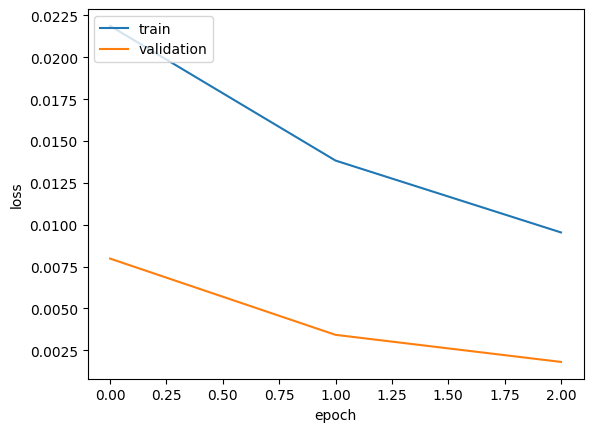

In [ ]:
plot_history(loss_history, ('train_loss','val_loss'))

##[Task-4 and 6] Training the Berttiny with train set in batches of size 1. generation of answers for model 2: Berttiny $f_{Θ}(P_{i}, Q_i)$

In [29]:
encoder_berttiny, decoder_berttiny, loss_history_berttiny = train(epoch =3, tokenizer=tokenizer2, model_name=model_name2)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

Loss - 0.03216099366545677- count -1
Loss - 0.1329289972782135- count -2
Loss - 0.037527456879615784- count -3
Loss - 0.13718581199645996- count -4
Loss - 0.11276533454656601- count -5
Loss - 0.05073218047618866- count -6
Loss - 0.06553547084331512- count -7
Loss - 0.021982979029417038- count -8
Loss - 0.021399933844804764- count -9
Loss - 0.020163513720035553- count -10
Loss - 0.01883925311267376- count -11
Loss - 0.017843887209892273- count -12
Loss - 0.029054613783955574- count -13
Loss - 0.0157154630869627- count -14
Loss - 0.040964897722005844- count -15
Loss - 0.04023178666830063- count -16
Loss - 0.013427929021418095- count -17
Loss - 0.012699075974524021- count -18
Loss - 0.022402601316571236- count -19
Loss - 0.011915433220565319- count -20
Loss - 0.020488422363996506- count -21
Loss - 0.1038142666220665- count -22
Loss - 0.07846641540527344- count -23
Loss - 0.009968248195946217- count -24
Loss - 0.00985699612647295- count -25
Loss - 0.04693535715341568- count -26
Loss - 0.03

 33%|███▎      | 1/3 [20:47<41:35, 1247.64s/it]

Loss - 0.0024157261941581964- count -1
Loss - 0.07144773751497269- count -2
Loss - 0.007339190226048231- count -3
Loss - 0.08404361456632614- count -4
Loss - 0.06873805820941925- count -5
Loss - 0.013222613371908665- count -6
Loss - 0.019217167049646378- count -7
Loss - 0.004037322476506233- count -8
Loss - 0.004430396482348442- count -9
Loss - 0.004740118980407715- count -10
Loss - 0.004506109748035669- count -11
Loss - 0.00406232662498951- count -12
Loss - 0.008541570045053959- count -13
Loss - 0.0038556831423193216- count -14
Loss - 0.013118738308548927- count -15
Loss - 0.012991935014724731- count -16
Loss - 0.003482024185359478- count -17
Loss - 0.0037827864289283752- count -18
Loss - 0.00792897678911686- count -19
Loss - 0.0031533429864794016- count -20
Loss - 0.008400744758546352- count -21
Loss - 0.06419719010591507- count -22
Loss - 0.039496179670095444- count -23
Loss - 0.00337801780551672- count -24
Loss - 0.0027992052491754293- count -25
Loss - 0.018989115953445435- count -

 67%|██████▋   | 2/3 [41:20<20:38, 1238.70s/it]

Loss - 0.0006066284840926528- count -1
Loss - 0.05054621398448944- count -2
Loss - 0.002232261933386326- count -3
Loss - 0.061759818345308304- count -4
Loss - 0.06063799932599068- count -5
Loss - 0.005558459088206291- count -6
Loss - 0.010095211677253246- count -7
Loss - 0.0007150066667236388- count -8
Loss - 0.0007180434186011553- count -9
Loss - 0.0008103214204311371- count -10
Loss - 0.000842101639136672- count -11
Loss - 0.0007921636570245028- count -12
Loss - 0.0036465877201408148- count -13
Loss - 0.0007914615562185645- count -14
Loss - 0.006140278186649084- count -15
Loss - 0.006085257511585951- count -16
Loss - 0.0007936087786220014- count -17
Loss - 0.0009124968200922012- count -18
Loss - 0.0035073026083409786- count -19
Loss - 0.0008081192499957979- count -20
Loss - 0.00307852984406054- count -21
Loss - 0.04560535028576851- count -22
Loss - 0.02669292874634266- count -23
Loss - 0.0006936233257874846- count -24
Loss - 0.0006906584021635354- count -25
Loss - 0.01019415166229009

100%|██████████| 3/3 [1:01:55<00:00, 1238.46s/it]


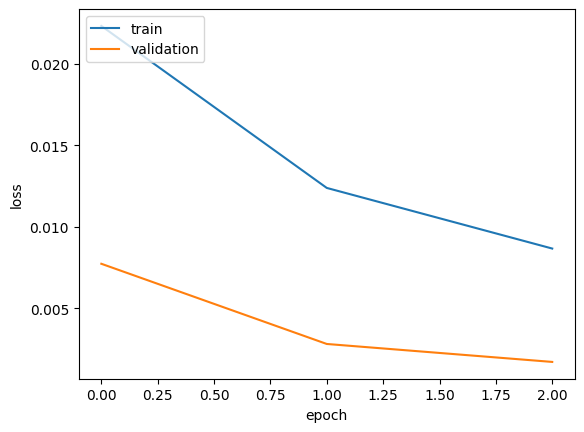

In [ ]:
plot_history(loss_history_berttiny, ('train_loss','val_loss'))

##[Task-5]generation of answers for model 1: DistilRoberta $f_{Θ}(P_{i}, Q_i, H_i)$

In [ ]:
encoder_distilroberta_history, decoder_distilroberta_history, loss_withh_dist = train(epoch =3, history=True, tokenizer=tokenizer1, model_name=model_name1)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
  0%|          | 0/3 [00:00<?, ?it/s]

Loss - 0.030427057296037674- count -1
Loss - 0.13524290919303894- count -2
Loss - 0.03805401548743248- count -3
Loss - 0.13553716242313385- count -4
Loss - 0.10158327221870422- count -5
Loss - 0.056272923946380615- count -6
Loss - 0.061991557478904724- count -7
Loss - 0.02442646585404873- count -8
Loss - 0.02302619256079197- count -9
Loss - 0.020702261477708817- count -10
Loss - 0.017473071813583374- count -11
Loss - 0.01340718474239111- count -12
Loss - 0.024505198001861572- count -13
Loss - 0.007815537042915821- count -14
Loss - 0.03406595438718796- count -15
Loss - 0.03159428387880325- count -16
Loss - 0.006763429846614599- count -17
Loss - 0.006780515890568495- count -18
Loss - 0.014078951440751553- count -19
Loss - 0.006542799063026905- count -20
Loss - 0.012163560837507248- count -21
Loss - 0.10787668079137802- count -22
Loss - 0.07020846009254456- count -23
Loss - 0.010857125744223595- count -24
Loss - 0.011783146299421787- count -25
Loss - 0.03660472854971886- count -26
Loss - 

 33%|███▎      | 1/3 [20:57<41:54, 1257.03s/it]

Loss - 0.003410457633435726- count -1
Loss - 0.07185005396604538- count -2
Loss - 0.008189236745238304- count -3
Loss - 0.09292299300432205- count -4
Loss - 0.06926092505455017- count -5
Loss - 0.014858495444059372- count -6
Loss - 0.019851122051477432- count -7
Loss - 0.006317510735243559- count -8
Loss - 0.006263485178351402- count -9
Loss - 0.006831696256995201- count -10
Loss - 0.007322417106479406- count -11
Loss - 0.006397641729563475- count -12
Loss - 0.010648537427186966- count -13
Loss - 0.00591537170112133- count -14
Loss - 0.01483161747455597- count -15
Loss - 0.014851161278784275- count -16
Loss - 0.004602131433784962- count -17
Loss - 0.0043638888746500015- count -18
Loss - 0.01031159982085228- count -19
Loss - 0.0038638412952423096- count -20
Loss - 0.010404284112155437- count -21
Loss - 0.06709298491477966- count -22
Loss - 0.04364782199263573- count -23
Loss - 0.0035615391097962856- count -24
Loss - 0.0037713132333010435- count -25
Loss - 0.023807289078831673- count -26

 67%|██████▋   | 2/3 [41:58<20:59, 1259.53s/it]

Loss - 0.0008467696025036275- count -1
Loss - 0.05718608200550079- count -2
Loss - 0.003657615976408124- count -3
Loss - 0.0697145164012909- count -4
Loss - 0.06672382354736328- count -5
Loss - 0.00880663562566042- count -6
Loss - 0.013304580003023148- count -7
Loss - 0.0016382839530706406- count -8
Loss - 0.0019136047922074795- count -9
Loss - 0.002039446262642741- count -10
Loss - 0.0020194589160382748- count -11
Loss - 0.002086447784677148- count -12
Loss - 0.005646455101668835- count -13
Loss - 0.0018890827195718884- count -14
Loss - 0.009146628901362419- count -15
Loss - 0.008941576816141605- count -16
Loss - 0.0016236129449680448- count -17
Loss - 0.0013982887612655759- count -18
Loss - 0.005404908675700426- count -19
Loss - 0.0012450109934434295- count -20
Loss - 0.005181481596082449- count -21
Loss - 0.051753923296928406- count -22
Loss - 0.03261232376098633- count -23
Loss - 0.0008988646441139281- count -24
Loss - 0.0009531326359137893- count -25
Loss - 0.015102023258805275- c

100%|██████████| 3/3 [1:03:15<00:00, 1265.01s/it]


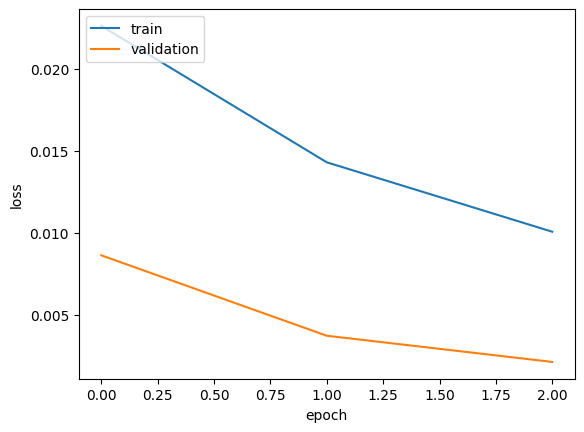

In [ ]:
plot_history(loss_withh_dist, ('train_loss','val_loss'))

##[Task-5]generation of answers for model 2: Berttiny $f_{Θ}(P_{i}, Q_i, H_i)$

In [ ]:
encoder_bert_history, decoder_bert_history, loss_withh_bert = train(epoch =2,history=True, tokenizer=tokenizer2, model_name=model_name2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

Loss - 0.031101202592253685- count -1
Loss - 0.1384771764278412- count -2
Loss - 0.03564465045928955- count -3
Loss - 0.14191658794879913- count -4
Loss - 0.08964483439922333- count -5
Loss - 0.04627150669693947- count -6
Loss - 0.053060293197631836- count -7
Loss - 0.022535480558872223- count -8
Loss - 0.020949505269527435- count -9
Loss - 0.018937265500426292- count -10
Loss - 0.01738918572664261- count -11
Loss - 0.015901723876595497- count -12
Loss - 0.024621792137622833- count -13
Loss - 0.012950100935995579- count -14
Loss - 0.036337628960609436- count -15
Loss - 0.03611259162425995- count -16
Loss - 0.010005813091993332- count -17
Loss - 0.00946329440921545- count -18
Loss - 0.018132833763957024- count -19
Loss - 0.008391192182898521- count -20
Loss - 0.017103618010878563- count -21
Loss - 0.12495221942663193- count -22
Loss - 0.07520076632499695- count -23
Loss - 0.00765174301341176- count -24
Loss - 0.00778765045106411- count -25
Loss - 0.035081103444099426- count -26
Loss - 0

 50%|█████     | 1/2 [19:46<19:46, 1186.35s/it]

Loss - 0.002693123184144497- count -1
Loss - 0.07192894071340561- count -2
Loss - 0.007036222610622644- count -3
Loss - 0.08585973083972931- count -4
Loss - 0.06044676527380943- count -5
Loss - 0.01221662387251854- count -6
Loss - 0.018134675920009613- count -7
Loss - 0.004124372266232967- count -8
Loss - 0.004328805021941662- count -9
Loss - 0.004207143560051918- count -10
Loss - 0.0044189393520355225- count -11
Loss - 0.004209039732813835- count -12
Loss - 0.008596568368375301- count -13
Loss - 0.0038013444282114506- count -14
Loss - 0.01298268511891365- count -15
Loss - 0.012654623948037624- count -16
Loss - 0.0038627884350717068- count -17
Loss - 0.004319099709391594- count -18
Loss - 0.007731860503554344- count -19
Loss - 0.0035779112949967384- count -20
Loss - 0.007581737823784351- count -21
Loss - 0.06118398904800415- count -22
Loss - 0.03638448938727379- count -23
Loss - 0.0029124191496521235- count -24
Loss - 0.0027490409556776285- count -25
Loss - 0.019197309389710426- count 

100%|██████████| 2/2 [39:31<00:00, 1185.84s/it]


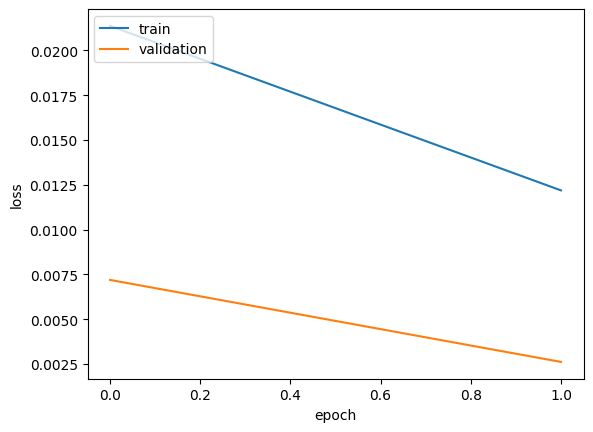

In [ ]:
plot_history(loss_withh_bert, ('train_loss','val_loss'))

##Initializing Falcon model and Pipeline for text generation from answer span

In [26]:
model = FalconForQuestionAnswering.from_pretrained("tiiuae/falcon-7b")

pipeline = transformers.pipeline(
    "text-generation",
    model="tiiuae/falcon-7b",
    tokenizer=tokenizer3,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto",
)


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of FalconForQuestionAnswering were not initialized from the model checkpoint at tiiuae/falcon-7b and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


configuration_falcon.py:   0%|          | 0.00/7.16k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b:
- configuration_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.



modeling_falcon.py:   0%|          | 0.00/56.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b:
- modeling_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

## Function to Generate the answer with Falcon
(Falcon is never trained. Only pre-trained model of 7B parameters is used. This function is doing inference)

In [25]:
def generativeQAwithFalcon(data,history=False):
    '''
    This function generates the answer. First Falcon extracts the answer span. Then the span is passed to the
    text-generation pipeline to generate the final answer.

    Input:

    data: Dataframe
    history: Bool

    Out:

    answer: String
    '''
    sequence = []
    answer_span = ''
    inputs,_ = prepare_train_features(data,use_Falcon=True,history=history, tokenizer=tokenizer3)
    output = model(input_ids = inputs['input_ids'], attention_mask = inputs['attention_mask'])
    start_logit, end_logit = output.start_logits.argmax(-1), output.end_logits.argmax(-1)
    if start_logit > end_logit:
       answer_span = data['context' if history else 'text'][end_logit : start_logit]
    else:
       answer_span = data['context' if history else 'text'][start_logit : end_logit]

    sequences = pipeline(
          answer_span,
          max_length=20,
          do_sample=True,
          top_k=10,
          num_return_sequences=1,
          eos_token_id=tokenizer3.eos_token_id,
          )
    for seq in sequences:
        sequence.append(seq['generated_text'])

    return sequence


##Evaluation

"""Functions taken from [the official evaluation script]
(https://worksheets.codalab.org/rest/bundles/0x6b567e1cf2e041ec80d7098f031c5c9e/contents/blob/)
for SQuAD version 2.0.

Modifications
-------------
* Modifications are applied to the name of some functions by adding an underscore to signal that their use is internal.
* Types and docstrings are added to the functions for clear readability.
* Parameter names of the functions are changed for better clarity on their meaning.
* The function `compute_f1` is changed to `_compute_squad_f1`.
* The function `normalize_answer` is rewritten.
* The function `compute_squad_f1` is added.

In [30]:
import collections
import numpy as np
import re
import string
import time
from typing import List


def _normalize_answer(answer: str) -> str:
    """Lower text and remove punctuation, articles and extra whitespace from an answer.
    Parameters
    ----------
    answer : str
        Answer to normalize.
    Returns
    -------
    str
        The normalized answer.
    """
    punctuation_to_exclude = set(string.punctuation)
    articles_regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)

    # Lowercase the string
    answer = answer.lower()
    # Remove punctuation
    answer = ''.join(ch for ch in answer if ch not in punctuation_to_exclude)
    # Remove articles
    answer = re.sub(articles_regex, ' ', answer)
    # Remove extra whitespace
    return ' '.join(answer.split())

def _get_tokens(input_string: str) -> List[str]:
    """Get the tokens of a string after it has been normalized.
    Parameters
    ----------
    answer : str
        Answer from which the tokens are obtained.
    Returns
    -------
    list of strings
        The tokens composing each string.
    """
    if not input_string:
        return []
    return _normalize_answer(input_string).split()

def compute_squad_f1(gold_answer: str, predicted_answer: str) -> float:
    """Compute the SQuAD f1 score on a true answer and its prediction.
    Parameters
    ----------
    gold_answer : str
        The true answer.
    predicted_answer : str
        The predicted answer.
    Returns
    -------
    float
        The SQuAD f1 score.
    """
    gold_tokens = _get_tokens(gold_answer)
    predicted_tokens = _get_tokens(predicted_answer)
    common = collections.Counter(gold_tokens) & collections.Counter(predicted_tokens)
    num_same = sum(common.values())

    if len(gold_tokens) == 0 or len(predicted_tokens) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_tokens == predicted_tokens)
    if num_same == 0:
        return 0.

    precision = 1.0 * num_same / len(predicted_tokens)
    recall = 1.0 * num_same / len(gold_tokens)

    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def validate(encoder = None,decoder = None,tokenizer=None,history=False, val_data= None) -> float:

    """Evaluate the model on the validation dataset according to the average SQuAD F1 score.
    Parameters
    ----------
    model : Model
        The model to evaluate.
    val_data : the validation set.
    use_history : bool
        Whether to use the previous QaA discussion history or not.
    Returns
    -------
    float, dict()
        The average SQuAD F1 score of the validation dataset and a sorted dictionary containing the answers
    """

    tot_squad_f1 = 0.
    total_n_instances = 0
    starting_time = time.time()


    trainer = MyTrainer(encoder=encoder,decoder=decoder)
    squad_list = []
    worst_answers_list =  []
    answer_dict = dict()

    for row in val_data.iterrows():
        batch2,_ = prepare_train_features(row[1],history=history, tokenizer=tokenizer)
        generated = trainer.generate(batch2)
        translated = trainer.translate(generated, batch2['output_tokenizer'])
        squad_value = compute_squad_f1(row[1]["answer"]['input_text'], translated)
        squad_list.append(squad_value)
        answer_dict[row[0]] = {'prediction': translated,
                               'ground_truth': row[1]["answer"]['input_text'],
                               'squad_value': squad_value,
                               'question': row[1]['question'],
                               'passage': row[1]['text']}
        total_n_instances +=  1

        print(f"{row[0] + 1}/{val_data.shape[0]}, {(time.time() - starting_time):.0f}s",
        f"{(time.time()-starting_time)/(row[0]+1)*1e3:.0f}ms/step, mean SQuAD F1: {tot_squad_f1/total_n_instances}",
        end='\r')
    tot_squad_f1 += np.sum(squad_list)
    #squad_f1_scores = np.array(squad_list)
    #samples_indices = np.argsort(squad_f1_scores)[:5]
    answer_dict = {k: v for k, v in sorted(answer_dict.items(), key=lambda item: item[1]['squad_value'])}
    # for idx in samples_indices:
    #     worst_answers_list.append(tuple([val_data.iloc[[idx]], squad_f1_scores[idx]]))

    return (tot_squad_f1 / total_n_instances), answer_dict

## Evaluation for Falcon

In [28]:
def validateFalcon(history=False, val_data= None) -> float:

    """Evaluate the model on the validation dataset according to the average SQuAD F1 score.
    Parameters
    ----------

    val_data : the validation set.
    history : bool
        Whether to use the previous QaA discussion history or not.
    Returns
    -------
    float, dict()
        The average SQuAD F1 score of the validation dataset and a sorted dictionary containing the answers
    """

    tot_squad_f1 = 0.
    total_n_instances = 0
    starting_time = time.time()


    squad_list = []
    worst_answers_list =  []
    answer_dict = dict()

    for row in val_data.iterrows():
        generated = generativeQAwithFalcon(row[1],history=history)
        squad_value = compute_squad_f1(row[1]["answer"]['input_text'], generated[0])
        squad_list.append(squad_value)
        answer_dict[row[0]] = {'prediction': generated[0],
                               'ground_truth': row[1]["answer"]['input_text'],
                               'squad_value': squad_value,
                               'question': row[1]['question'],
                               'passage': row[1]['text']}
        total_n_instances +=  1


        print(f"{row[0] + 1}/{val_data.shape[0]}, {(time.time() - starting_time):.0f}s",
        f"{(time.time()-starting_time)/(row[0]+1)*1e3:.0f}ms/step, mean SQuAD F1: {tot_squad_f1/total_n_instances}",
        end='\r')

    tot_squad_f1 += np.sum(squad_list)
    #squad_f1_scores = np.array(squad_list)
    #samples_indices = np.argsort(squad_f1_scores)[:5]
    answer_dict = {k: v for k, v in sorted(answer_dict.items(), key=lambda item: item[1]['squad_value'])}
    # for idx in samples_indices:
    #     worst_answers_list.append(tuple([val_data.iloc[[idx]], squad_f1_scores[idx]]))

    return (tot_squad_f1 / total_n_instances), answer_dict

##Evaluation of Falcon without history

In [ ]:
result, _ = validateFalcon(val_data=test)
print(f'F1- SQAD score for Falcon without history-- {result}')

The current implementation of Falcon calls `torch.scaled_dot_product_attention` directly, this will be deprecated in the future in favor of the `BetterTransformer` API. Please install the latest optimum library with `pip install -U optimum` and call `model.to_bettertransformer()` to benefit from `torch.scaled_dot_product_attention` and future performance optimizations.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 39, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 40, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 43, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 42, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 67, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 66, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 63, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 64, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 65, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 61, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 62, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 41, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 38, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 49, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 48, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 47, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 100, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 99, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 71, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 98, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 91, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 80, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 90, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 72, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 92, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 56, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 57, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 55, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 54, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 33, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 31, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 32, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 35, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 51, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 50, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 45, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 36, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 44, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 52, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 88, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 89, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 37, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 58, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 77, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 76, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 78, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 75, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 70, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 74, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 46, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 34, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 28, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 25, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 24, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 22, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 23, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 93, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 94, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 95, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 27, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 26, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 53, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


F1- SQAD score for Falcon without history-- 0.609266305026176


##Evaluation of Flacon with History

In [ ]:
result, _ = validateFalcon(history=True, val_data=test)
print(f'F1- SQAD score for Falcon with history-- {result}')

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


F1- SQAD score for Falcon with history-- 0.619266302465176


##Evaluation result for DistilRoberta without history

In [ ]:
result, _ = validate(encoder=encoder_distilroberta,decoder= decoder_distilroberta,tokenizer=tokenizer1, val_data=test)
print(f'F1- SQAD score for distilroberta without history-- {result}')

F1- SQAD score for distilroberta without history-- 0.7396630507417596


##Evaluation result for Berttiny without history

In [31]:
result, comparison_data = validate(encoder=encoder_berttiny,decoder= decoder_berttiny,tokenizer=tokenizer2, val_data=validation_combined)
print(f'F1- SQAD score for berttiny without history-- {result}')

F1- SQAD score for berttiny without history-- 0.7397907157837514


##Evaluation result for DistilRoberta with history

In [ ]:
result, _ = validate(encoder=encoder_distilroberta_history,decoder= decoder_distilroberta_history,tokenizer=tokenizer1,history=True, val_data=test)
print(f'F1- SQAD score for distilroberta with history-- {result}')

##Evaluation result for Berttiny with history

In [ ]:
result, _ = validate(encoder=encoder_bert_history,decoder= decoder_bert_history,tokenizer=tokenizer2,history=True, val_data=test)
print(f'F1- SQAD score for berttiny with history-- {result}')

##Results

#DistilRoberta

Validation Squad F1 score without history:

Seed 42: 0.73256\
Seed 2022: 0.73166\

Validation Squad F1 score with history:

Seed 42: 0.72323\
Seed 2022: 0.72522\

Test Squad F1 score without history:

Seed 42: 0.73228\
Seed 2022: 0.73159\

Test Squad F1 score with history:

Seed 42: 0.72222\
Seed 2022: 0.72526\

#Berttiny

Validation Squad F1 score without history:

Seed 42: 0.74345\
Seed 2022: 0.74425\

Validation Squad F1 score with history:

Seed 42: 0.73787\
Seed 2022: 0.72052\

Test Squad F1 score without history:

Seed 42: 0.74672\
Seed 2022: 0.74263\

Test Squad F1 score with history:

Seed 42: 0.72323\
Seed 2022: 0.72436\


## Falcon

Test set Squad F1 score without history:

Seed 42: 0.60926\
Seed 2022 : 0.60026\

Test set Sqad F1 score with history

Seed 42: 0.61343 \
Seed 2022: 0.60152\

Validation set Squad F1 score without history:

Seed 42: 0.60251\
Seed 2022 : 0.60129\

Validation set Sqad F1 score with history

Seed 42: 0.60695 \
Seed 2022: 0.60513\

##[Task 7] Error Analysis

The error analysis is performed on  distilroberta-base, prajjwal1/bert-tiny and Falcon models while considering the combination of the two hyperparameters seed and use_history that led to the best SQuAD F1 scores on the validation dataset, namely:

\textbf{distilroberta-base}
1.   seed = 42
2.   use_history = False


\textbf{prajjwal1/bert-tiny}
1.  seed = 42
2.   use_history = False


The error analysis is performed on the test dataset, while considering the worst
 errors in generating the answers according to the SQuAD F1 score for each source.

The errors are analysed by taking into account the considerations expressed in the paper CoQA: A Conversational Question Answering Challenge.

In [ ]:
grouped_test_df = test.groupby(by=['source'])
print(f'Number of sources: {len(grouped_test_df)}')
print(f'Source names: {"; ".join([key for key, _ in grouped_test_df])}.')

Number of sources: 5
Source names: cnn; gutenberg; mctest; race; wikipedia.


<ipython-input-16-2220778de744>:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  print(f'Source names: {"; ".join([key for key, _ in grouped_test_df])}.')


## DistilRoberta

##cnn as source

In [ ]:
cnn = test.loc[test['source']=='cnn']

In [ ]:
_, worst_answers = validate(encoder=encoder_distilroberta,decoder= decoder_distilroberta,tokenizer=tokenizer1, val_data=cnn)

In [ ]:
count=0
for k,v in worst_answers.items():
    count+=1
    print(f'* prediction-- ', v['prediction'])
    print(f'* ground_truth-- ', v['ground_truth'])
    print(f'* question -- ', v['question'])
    print(f'* squad_value -- ', v['squad_value'])
    print('---------------------')
    if count==5:
      break


* prediction--   <start>  <end> 
* ground_truth--  He gave the English side the lead
* question --  what did Striker Bobby Zamora do?
* squad_value --  0.0
---------------------
* prediction--   <start>  coercion  a 
* ground_truth--  coercion of a public servant and abuse of his official capacity
* question --  What does he face accusations of?
* squad_value --  0.16666666666666669
---------------------
* prediction--   mexico  chief  in  been  <start>  of 
* ground_truth--  MEXICO CITY, Mexico (CNN) -- The police chief in Cancún has been relieved of his duties and placed under house arrest while he is investigated in the killing of a retired Mexican general who had been the area's anti-drug chief for less than 24 hours, Mexican media are reporting.
* question --  What did he do?
* squad_value --  0.19999999999999998
---------------------
* prediction--   <start>  blaze  of 
* ground_truth--  The blaze is burning on Possum Kingdom Lake, near the town of Brad, about 100 miles west of D

For the first answer, the model generated nothing. It seems that the text extractor could not extract the text answer span for the given question.

For the second answer, the model only able to produce a partial answer. Thought the ground truth is more detailed, but the predicted answer is not completly irrelevant or out of context.

For the 3rd, 4th,5th prediction, the model could not predict the long answer that is required by the question. If we look at the ground truth text span it is quite lengthy as compared to the previous text spans. So, the conclusion is the model is unable to generate very long text span.

##gutenberg as source.

In [ ]:
gutenberg = test.loc[test['source']=='gutenberg']

In [ ]:
_, worst_answers = validate(encoder=encoder_distilroberta,decoder= decoder_distilroberta,tokenizer=tokenizer1, val_data=gutenberg)

In [ ]:
count=0
for k,v in worst_answers.items():
    count+=1
    print(f'* prediction-- ', v['prediction'])
    print(f'* ground_truth-- ', v['ground_truth'])
    print(f'* question -- ', v['question'])
    print(f'* squad_value -- ', v['squad_value'])
    print('---------------------')
    if count==5:
      break

* prediction--   <start>  <end> 
* ground_truth--  Week after week
* question --  how often was convoys deployed?
* squad_value --  0.0
---------------------
* prediction--   <start>  <end> 
* ground_truth--  "Thief! thief! thief!
* question --  What was he saying while doing so?
* squad_value --  0.0
---------------------
* prediction--   in  of  to 
* ground_truth--  The victory was considered as wholly due to the extraordinary military energy and skill of Pyrrhus, and not to any superiority of the Greek troops over those of the Romans in courage, in discipline, or in efficiency in the field.
* question --  Why?
* squad_value --  0.15789473684210528
---------------------
* prediction--   had  of  up  from  snuggers, 
* ground_truth--  Peleg Snuggers, the general utility man of the Hall, had just brought the boys up from Cedarville, to which place they had journeyed from Ithaca on the regular afternoon boat running up Cayuga Lake. With the Rovers had come Fred Garrison, Larry Colby, a

The worst answers for the source gutenberg also similar to cnn as source.

For the first and second answer in the prediction is completly blank. That means the model unable to extract the correct span.

For the ansers in the 3rd,4th and 5th the ground truth is too large. The text extactor was unable to extract the full span. So the generted answer contains only few words from the text span

##mctest as source.

In [ ]:
mctest = test.loc[test['source']=='mctest']

In [ ]:
_, worst_answers = validate(encoder=encoder_distilroberta,decoder= decoder_distilroberta,tokenizer=tokenizer1, val_data=mctest)

In [ ]:
count=0
for k,v in worst_answers.items():
    count+=1
    print(f'* prediction-- ', v['prediction'])
    print(f'* ground_truth-- ', v['ground_truth'])
    print(f'* question -- ', v['question'])
    print(f'* squad_value -- ', v['squad_value'])
    print('---------------------')
    if count==5:
      break

* prediction--   <start>  all  of  the  would 
* ground_truth--  All of the other alligators would laugh and point at him and say mean things about him.
* question --  How did wearing them negatively impact him?
* squad_value --  0.3
---------------------
* prediction--   <start>  help  us  the  get 
* ground_truth--  they help us get down to the little person world when we need to
* question --  Why are they important?
* squad_value --  0.3529411764705882
---------------------
* prediction--   wrestle  a  big 
* ground_truth--  wrestle a big plastic alligator with tape over its mouth
* question --  What did Happy do in his act?
* squad_value --  0.3636363636363636
---------------------
* prediction--   <start>  because  he 
* ground_truth--  Because he didn't have to go to school.
* question --  Why?
* squad_value --  0.36363636363636365
---------------------
* prediction--   remembered  why  <start> 
* ground_truth--  She remembered why she wasn't feeling like herself
* question --  

For all the worst answers in the source mctest also occured due to the fact that the model is unable to extract and generate the full text span for the answer. So the model only predicts a part of the text span causing low f1 score.

##race as source.

In [ ]:
race = test.loc[test['source']=='race']

In [ ]:
_, worst_answers = validate(encoder=encoder_distilroberta,decoder= decoder_distilroberta,tokenizer=tokenizer1, val_data=race)

In [ ]:
count=0
for k,v in worst_answers.items():
    count+=1
    print(f'* prediction-- ', v['prediction'])
    print(f'* ground_truth-- ', v['ground_truth'])
    print(f'* question -- ', v['question'])
    print(f'* squad_value -- ', v['squad_value'])
    print('---------------------')
    if count==5:
      break

* prediction--   <start>  <end> 
* ground_truth--  Liar Liar
* question --  What movie has Jim Carrey in it?
* squad_value --  0.0
---------------------
* prediction--   <start>  <end> 
* ground_truth--  word for word
* question --  When he was young how did he retell stories?
* squad_value --  0.0
---------------------
* prediction--   from  an  <start> 
* ground_truth--  From an early age she had tried hard to be kind and friendly to everyone.
* question --  Why not?
* squad_value --  0.125
---------------------
* prediction--   a  they  <start>  grimesby 
* ground_truth--  Grimesby Roylott. He comes from a rich family. But they are no longer rich. They have nothing except a small piece of land and
* question --  Does the stepfather have friends ?
* squad_value --  0.16
---------------------
* prediction--   to  us  team  arrived  <start> 
* ground_truth--  hen the US team arrived for the Olympics, Lang, 48, who is from Beijing, had to take a different route to avoid a crowd of repor

Similar scenario is observed for the source race.
for the answers having prediction f1 score 0 the model generated nothing. This is due to most probably the text extractor could not extract the text span as a result the encoder decoder could not generate the answer.

For the 3rd,4th and fifth answers, the text extractor could not extract the whole text span as a result the generated answer only constains few words. But an important observation can be made from the 4th question. The ground truth answer do not seem to be much coherent with the question. So the model is not able to answer without the history provided.

##wikipedia as source

In [ ]:
wikipedia = test.loc[test['source']=='wikipedia']

In [ ]:
_, worst_answers = validate(encoder=encoder_distilroberta,decoder= decoder_distilroberta,tokenizer=tokenizer1, val_data=wikipedia)

In [ ]:
count=0
for k,v in worst_answers.items():
    count+=1
    print(f'* prediction-- ', v['prediction'])
    print(f'* ground_truth-- ', v['ground_truth'])
    print(f'* question -- ', v['question'])
    print(f'* squad_value -- ', v['squad_value'])
    print('---------------------')
    if count==5:
      break

* prediction--   .  <end> 
* ground_truth--  .
* question --  I realize, thank you. I wanted another unknown answer.
* squad_value --  0
---------------------
* prediction--   protectorate  <start>  the 
* ground_truth--  the Southern Nigeria Protectorate and Northern Nigeria Protectorate in 1914.
* question --  what merging happened?
* squad_value --  0.1818181818181818
---------------------
* prediction--   <start>  to  their 
* ground_truth--  to portray persons or social institutions as ridiculous or corrupt, thus alienating their audience from the object of their humour.
* question --  How does satire and political satire use comedy?
* squad_value --  0.18181818181818182
---------------------
* prediction--   of  <start>  a  graphic  genre  literature, 
* ground_truth--  a genre of literature, and sometimes graphic and performing arts, in which vices, follies, abuses, and shortcomings are held up to ridicule, ideally with the intent of shaming individuals, corporations, government

The first genrated answer was correct actually but a spurious token got added <end> causing f1 score to be 0. For the second question, the generated answer is partially correct as the ground truth answer says the merging happened of 2 Protectorate.

For the 3rd,4th and 5th answers, the ground truth text span is too long. So the text extractor could not extract the whole text span. So the encoder decoder generated only a few words from the ground truth span.

##Recap

From the above error analysis of the worst answers, it is observed that the model is mainly unable to generate answers if the ground truth answer span is too long. This might be the case because the model is trained only for 3 epochs and for 500 data points each epoch. If trained for more data points and more epochs, we think the model would have generate better answers.

##Berttiny

#cnn as source

In [ ]:
cnn = test.loc[test['source']=='cnn']
_, worst_answers = validate(encoder=encoder_berttiny,decoder= decoder_berttiny,tokenizer=tokenizer2, val_data=cnn)
count=0
for k,v in worst_answers.items():
    count+=1
    print(f'* prediction-- ', v['prediction'])
    print(f'* ground_truth-- ', v['ground_truth'])
    print(f'* question -- ', v['question'])
    print(f'* squad_value -- ', v['squad_value'])
    print('---------------------')
    if count==5:
      break

* prediction--   and  the  <start>  a 
* ground_truth--  a wooden cane, holding it against her throat for several seconds and punching her in the throat and stomach, according to the police affidavit.
* question --  How did it happen?
* squad_value --  0.08695652173913042
---------------------
* prediction--   a  <start>  the  mexican 
* ground_truth--  a Mexican newspaper named Gonzalez as an informant in the arrest of the high-ranking cartel member
* question --  What happened at the same time Gonzalez left Mexico?
* squad_value --  0.14285714285714285
---------------------
* prediction--   out  the  of  <start> 
* ground_truth--  The Forest Service pulled out of its command observation post, telling journalists and onlookers to get out of the way of the flames.
* question --  Do they have any advice for people who are just watching it?
* squad_value --  0.1739130434782609
---------------------
* prediction--   war  to  the  <start> 
* ground_truth--  There are those who want me to c

In this source, no f1 score has value 0. But with the low scoring predictions it is observed that the model here too is unable to predict long answer spans.
It is because the text extractor is unable to extract the whole span of the text.

But if we look at the ground truth text of 3rd sample, it contains some unneseccery information with respect to the question. As the question asks what advice given. The actual answer would be "get out of the way of the flames". Where if we look at the predicted answer it outputs "out the of" which can be considered partially correct answer.

#gutenberg as source.

In [ ]:
gutenberg = test.loc[test['source']=='gutenberg']
_, worst_answers = validate(encoder=encoder_berttiny,decoder= decoder_berttiny,tokenizer=tokenizer2, val_data=gutenberg)
count=0
for k,v in worst_answers.items():
    count+=1
    print(f'* prediction-- ', v['prediction'])
    print(f'* ground_truth-- ', v['ground_truth'])
    print(f'* question -- ', v['question'])
    print(f'* squad_value -- ', v['squad_value'])
    print('---------------------')
    if count==5:
      break

* prediction--   of  up  from  <start> 
* ground_truth--  Peleg Snuggers, the general utility man of the Hall, had just brought the boys up from Cedarville, to which place they had journeyed from Ithaca on the regular afternoon boat running up Cayuga Lake. With the Rovers had come Fred Garrison, Larry Colby, and several others of their old school chums.
* question --  who went?
* squad_value --  0.12
---------------------
* prediction--   of  the  had  <start> 
* ground_truth--  They had not been out of the stable and with roar of the automobile, had so gotten on their nerves that to calm them was impossible.
* question --  Why not?
* squad_value --  0.14814814814814814
---------------------
* prediction--   of  the  in  to  victory 
* ground_truth--  The victory was considered as wholly due to the extraordinary military energy and skill of Pyrrhus, and not to any superiority of the Greek troops over those of the Romans in courage, in discipline, or in efficiency in the field.
* questi

First 3 cases, the questions are bit ambiguous without the previous conversation history. And the ground truth text span is also too long. So the model without the history, is unable to generate the fully correct response.

The last question is also bit ambiguous without the presence of history. And the text span is too long. So the model is unable to predict the fully correct answer.

The 4th question's predicted answer is completely incomplete and meaningless. Though it generating the text from the ground truth answer span but it is meaningless.

#mctest as source.

In [ ]:
mctest = test.loc[test['source']=='mctest']
_, worst_answers = validate(encoder=encoder_berttiny,decoder= decoder_berttiny,tokenizer=tokenizer2, val_data=mctest)
count=0
for k,v in worst_answers.items():
    count+=1
    print(f'* prediction-- ', v['prediction'])
    print(f'* ground_truth-- ', v['ground_truth'])
    print(f'* question -- ', v['question'])
    print(f'* squad_value -- ', v['squad_value'])
    print('---------------------')
    if count==5:
      break

* prediction--   for  him  the  <start> 
* ground_truth--  His adult neighbor, the scientist, had asked him to watch it for him for the weekend.
* question --  Why?
* squad_value --  0.23529411764705882
---------------------
* prediction--   lifted  the  <start>  up 
* ground_truth--  lifted up her line and took the small fish out of the water.
* question --  What did leah do next?
* squad_value --  0.28571428571428575
---------------------
* prediction--   all  of  and  <start> 
* ground_truth--  All of the other alligators would laugh and point at him and say mean things about him.
* question --  How did wearing them negatively impact him?
* squad_value --  0.3
---------------------
* prediction--   it  do  you  <start> 
* ground_truth--  You either do it right, or Ill do it right and you won't get a surprise
* question --  What did she say?
* squad_value --  0.31578947368421056
---------------------
* prediction--   <start>  the  best  new  to 
* ground_truth--  the best way to meet

The first case, the question is bit ambiguous without the presence of history. The ground truth is also too long. The generated answer is out of relevance. Similar, observations can be made for other 4 cases. The predicted answer is completelty out of context. They contain only few words from the ground truth text span.

#race as source.

In [ ]:
mctest = test.loc[test['source']=='mctest']
_, worst_answers = validate(encoder=encoder_berttiny,decoder= decoder_berttiny,tokenizer=tokenizer2, val_data=mctest)
count=0
for k,v in worst_answers.items():
    count+=1
    print(f'* prediction-- ', v['prediction'])
    print(f'* ground_truth-- ', v['ground_truth'])
    print(f'* question -- ', v['question'])
    print(f'* squad_value -- ', v['squad_value'])
    print('---------------------')
    if count==5:
      break

* prediction--   "if 
* ground_truth--  "If you clean up your room there is a great surprise in it for you
* question --  What?
* squad_value --  0.13333333333333333
---------------------
* prediction--   <start>  june  used  the 
* ground_truth--  June used the book to show Mary how the rain was good for the earth.
* question --  how did june change her mind?
* squad_value --  0.26666666666666666
---------------------
* prediction--   all  <start>  and  of 
* ground_truth--  All of the other alligators would laugh and point at him and say mean things about him.
* question --  How did wearing them negatively impact him?
* squad_value --  0.3
---------------------
* prediction--   it  <start>  either  right, 
* ground_truth--  You either do it right, or Ill do it right and you won't get a surprise
* question --  What did she say?
* squad_value --  0.31578947368421056
---------------------
* prediction--   the  best  new  to  <start> 
* ground_truth--  the best way to meet new friends wa

The first question is ambiguous. Maybe with the presence of the history a better coherency could have been found. As a result the model also could not predict the correct answer. It has generated only one text from the ground truth text span.

Similarly the second question also required the history to make coherency with the ground truth text span. Here also the predicted answer is incomplete.

For the 3rd,4th and 5th casees, the model abled to generated partial text as answer when compared to ground truth answer span.

#wikipedia as source

In [ ]:
wikipedia = test.loc[test['source']=='wikipedia']
_, worst_answers = validate(encoder=encoder_berttiny,decoder= decoder_berttiny,tokenizer=tokenizer2, val_data=wikipedia)
count=0
for k,v in worst_answers.items():
    count+=1
    print(f'* prediction-- ', v['prediction'])
    print(f'* ground_truth-- ', v['ground_truth'])
    print(f'* question -- ', v['question'])
    print(f'* squad_value -- ', v['squad_value'])
    print('---------------------')
    if count==5:
      break

* prediction--   .  <end> 
* ground_truth--  .
* question --  I realize, thank you. I wanted another unknown answer.
* squad_value --  0
---------------------


This is the only source for which berttiny has a case with 0 f1 score. But upon seeing the output we can say the output is correct with respect to the ground truth. But still the f1 score is 0 because an extra token got inserted.

##Final Conclusion

After all the above analysis, we can conclude that berttiny performed better than distilroberta and Falcon withoout using history in both the models. Both of the models, faced difficulties for long ground truth text span. This is due to the fact that both of the models could have performed better if trained for more epochs and more datapoints. Regarding Falcon, we can infer that if we train the model on CoQa it will be able to provide better F1 score.

## F1 Score Analysis with respect to Ground truth and prediction generated answer length for best model that is Berttiny without history on validation set seed:42

In [55]:
validation_ground_truth = []
validation_prediction = []
f1_score_value = []
for k,v in comparison_data.items():
   validation_ground_truth.append(v['ground_truth'])
   validation_prediction.append(v['prediction'])
   f1_score_value.append(v['squad_value']*100)



In [56]:
compare_answer_length =dict()
length_gT = []
length_pre = []

for idx, i in enumerate(validation_ground_truth):
  length_gT.append(len(i))
  length_pre.append(len(validation_prediction[idx]))


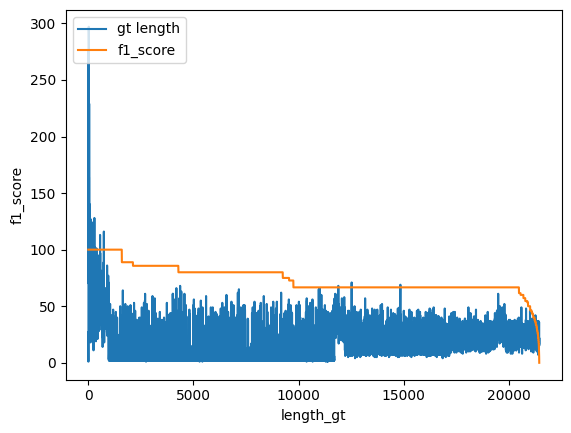

In [66]:
plt.plot(length_gT)
plt.plot(f1_score_value)
plt.ylabel('f1_score')
plt.xlabel('length_gt')
plt.legend(['gt length', 'f1_score'], loc='upper left')
plt.show()

Above graph is a plot of ground truth answer length and corresponding F1 score. We see that maximum ground truth answer is of length 0 and the F1 score is higher. As the length of ground truth increases the F1 score decreases.

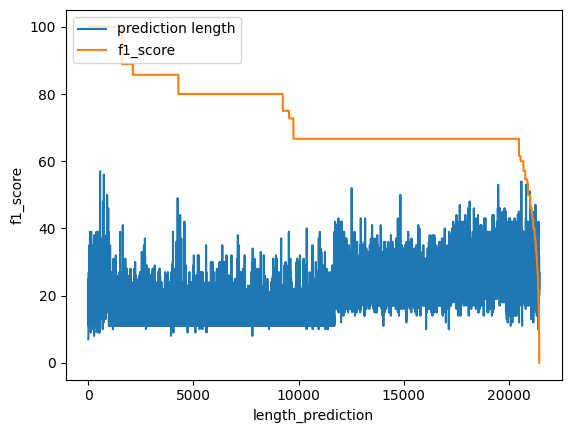

In [67]:
plt.plot(length_pre)
plt.plot(f1_score_value)
plt.ylabel('f1_score')
plt.xlabel('length_prediction')
plt.legend(['prediction length', 'f1_score'], loc='upper left')
plt.show()

Above graph is a plot of prediction generated answer length and corresponding F1 score. We see that maximum predicted generated answer is of length less than 5000 and the F1 score is higher. As the length of generated answer increases the F1 score decreases.

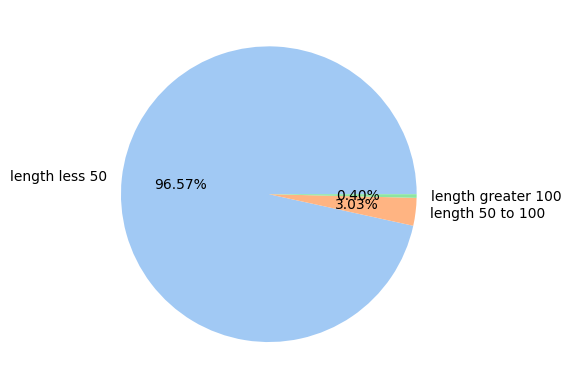

In [80]:
import seaborn as sns

count_less_5k = 0
count_5k_10k = 0
count_gt_10k = 0
for i in length_gT:
  if i<=50:
    count_less_5k += 1
  if i>50 and i<=100:
    count_5k_10k += 1
  if i>100:
    count_gt_10k += 1

percentage_less_5k = float(count_less_5k / len(validation_ground_truth))*100
percentage_5k_10k = float(count_5k_10k / len(validation_ground_truth))*100
percentage_gt_10k = float(count_gt_10k / len(validation_ground_truth))*100

percentages = [percentage_less_5k, percentage_5k_10k, percentage_gt_10k]
labels = ['length less 50', 'length 50 to 100', 'length greater 100']

colors = sns.color_palette('pastel')[0:3]

plt.pie(percentages, labels = labels, colors = colors, autopct='%.2f%%')
plt.show()

The above pie chart shows the distribution of the length of answers in ground truth. We can see that 96% answers are of length less than 50

## These 2 graphs proves that the architecture is performing poorly in generation with longer length ground truth answers